In [40]:
import numpy as np
import scipy.linalg as la
from scipy.sparse import spdiags
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [37]:
def startingPoint(G, c, A, b, guess):
    """
    Obtain an appropriate initial point for solving the QP 
    .5 x^T Gx + x^T c s.t. Ax >= b.
    Inputs:
    G -- symmetric positive semidefinite matrix shape (n,n)
    c -- array of length n
    A -- constraint matrix shape (m,n)
    b -- array of length m
    guess -- a tuple of arrays (x, y, l) of lengths n, m, and m, resp.
    Returns:
    a tuple of arrays (x0, y0, l0) of lengths n, m, and m, resp.
    """
    m,n = A.shape
    x0, y0, l0 = guess
    # initialize linear system
    N = np.zeros((n+m+m, n+m+m))
    N[:n,:n] = G
    N[:n, n+m:] = -A.T
    N[n:n+m, :n] = A
    N[n:n+m, n:n+m] = -np.eye(m)
    N[n+m:, n:n+m] = np.diag(l0)
    N[n+m:, n+m:] = np.diag(y0)
    rhs = np.empty(n+m+m)
    rhs[:n] = -(G.dot(x0) - A.T.dot(l0)+c)
    rhs[n:n+m] = -(A.dot(x0) - y0 - b)
    rhs[n+m:] = -(y0*l0)
    sol = la.solve(N, rhs)
    dx = sol[:n]
    dy = sol[n:n+m]
    dl = sol[n+m:]
    y0 = np.maximum(1, np.abs(y0 + dy))
    l0 = np.maximum(1, np.abs(l0+dl))
    return x0, y0, l0

# Constructing Interior Point Solver 
# (Problem 1, 2)

In [38]:
def qInteriorPoint(Q,c,A,b,guess,niter=20,tol=1e-16):
    m,n = A.shape
    sigma = 1/10
    tau = 0.95
    row1 = np.hstack((Q,np.zeros((n,m)),-A.T))
    row2 = np.hstack((A,-np.eye(m),np.zeros((m,m))))
    DF1 = np.vstack((row1,row2))
    x,y,mu = startingPoint(Q, c, A, b, guess)
    duality = (y@mu)/m
    iteration = 0
    
    def vector_F(x,y,mu):
        row1 = Q@x-A.T@mu+c
        row2 = A@x-y-b
        row3 = np.diag(y)@(np.diag(mu)@np.ones(m))
        F = np.hstack((row1,row2,row3))
        return F
    
    while duality >= tol and iteration < niter:
        # Find direction
        row3 = np.hstack((np.zeros((m,n)),np.diag(mu),np.diag(y)))
        DF = np.vstack((DF1,row3))
        bvec = np.hstack((np.zeros(n+m),duality*sigma*np.ones(m)))-vector_F(x,y,mu)
        direction = la.lu_solve(la.lu_factor(DF),bvec)
       
        # Find step size
        del_x = direction[:n]
        del_y = direction[n:-m]
        del_mu = direction[-m:]
        beta_max = min(1,np.min(-mu[del_mu<0]/del_mu[del_mu<0]))
        delta_max = min(1,np.min(-y[del_y<0]/del_y[del_y<0]))
        beta = min(1,tau*beta_max)
        delta = min(1,tau*delta_max)
        alpha = min(beta,delta)

        # Next point
        x = x+alpha*del_x
        y = y+alpha*del_y
        mu = mu+alpha*del_mu
        duality = (y@mu)/m
        iteration += 1
        print('Duality:', duality, 'on iteration', iteration)
        
    return x, c@x

In [39]:
x = np.array([1/2,1/2])
y = np.ones(5)
mu = np.ones(5)
guess = (x,y,mu)
c = np.array([-2,-6])
Q = np.array([[1,-1],[-1,2]])
A = np.array([[-1,-1],[1,-2],[-2,-1],[1,0],[0,1]])
b = np.array([-2,-2,-3,0,0])
print(qInteriorPoint(Q,c,A,b,guess))

Duality: 0.250466780797 on iteration 1
Duality: 0.126003419989 on iteration 2
Duality: 0.0428048440472 on iteration 3
Duality: 0.00780515664659 on iteration 4
Duality: 0.00120645224731 on iteration 5
Duality: 0.000176277948144 on iteration 6
Duality: 2.55786408208e-05 on iteration 7
Duality: 3.70920346842e-06 on iteration 8
Duality: 5.37840205737e-07 on iteration 9
Duality: 7.79869452909e-08 on iteration 10
Duality: 1.13081094625e-08 on iteration 11
Duality: 1.6396759222e-09 on iteration 12
Duality: 2.37753009771e-10 on iteration 13
Duality: 3.44741864389e-11 on iteration 14
Duality: 4.9987570341e-12 on iteration 15
Duality: 7.24819769955e-13 on iteration 16
Duality: 1.05098866644e-13 on iteration 17
Duality: 1.52393356633e-14 on iteration 18
Duality: 2.20970367118e-15 on iteration 19
Duality: 3.20407032322e-16 on iteration 20
(array([ 0.66666667,  1.33333333]), -9.3333333333333321)


# Problem 3

In [44]:
def circus_tent(n):
    def laplacian(n):
        """Construct the discrete Dirichlet energy matrix H for an n x n grid."""
        data = -1*np.ones((5, n**2))
        data[2,:] = 4
        data[1, n-1::n] = 0
        data[3, ::n] = 0
        diags = np.array([-n, -1, 0, 1, n])
        return spdiags(data, diags, n**2, n**2).toarray()
    
    # Create the tent pole configuration.
    L = np.zeros((n,n))
    L[n//2-1:n//2+1,n//2-1:n//2+1] = .5
    m = [n//6-1, n//6, int(5*(n/6.))-1, int(5*(n/6.))]
    mask1, mask2 = np.meshgrid(m, m)
    L[mask1, mask2] = .3
    L = L.ravel()
    
    # Set initial guesses.
    x = np.ones((n,n)).ravel()
    y = np.ones(n**2)
    mu = np.ones(n**2)
    
    # INITIALIZE c, A, H 
    H = laplacian(n)
    A = np.eye(len(x))
    c = -((n-1)**(-2))*np.ones_like(x)
    
    # Calculate the solution.
    z = qInteriorPoint(H, c, A, L, (x,y,mu))[0].reshape((n,n))
    
    # Plot the solution.
    domain = np.arange(n)
    X, Y = np.meshgrid(domain, domain)
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(X, Y, z, rstride=1, cstride=1, color='r')
    plt.show()

Duality: 0.192861320761 on iteration 1
Duality: 0.0598035137811 on iteration 2
Duality: 0.0193604905518 on iteration 3
Duality: 0.00597666879624 on iteration 4
Duality: 0.00285483027092 on iteration 5
Duality: 0.000942273195622 on iteration 6
Duality: 0.000200341168071 on iteration 7
Duality: 3.35935938702e-05 on iteration 8
Duality: 5.00802921204e-06 on iteration 9
Duality: 7.28778249718e-07 on iteration 10
Duality: 1.05722802391e-07 on iteration 11
Duality: 1.53308181761e-08 on iteration 12
Duality: 2.2229896319e-09 on iteration 13
Duality: 3.22333936069e-10 on iteration 14
Duality: 4.67384299548e-11 on iteration 15
Duality: 6.7770725373e-12 on iteration 16
Duality: 9.82675521983e-13 on iteration 17
Duality: 1.42487950773e-13 on iteration 18
Duality: 2.06607528639e-14 on iteration 19
Duality: 2.9958091653e-15 on iteration 20


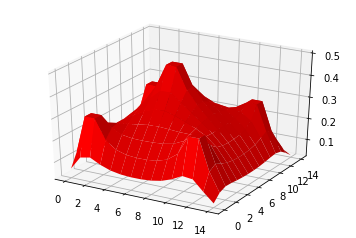

In [47]:
circus_tent(15)